# 7. Validation

## Google colab

In [188]:
%load_ext autoreload
%autoreload 2

import sys

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
  from google.colab import drive
  drive.mount('/content/drive')
  !rm -rf cfr2sbvr configuration checkpoint
  !git clone https://github.com/asantos2000/master-degree-santos-anderson.git cfr2sbvr
  %pip install -r cfr2sbvr/code/requirements.txt
  !cp -r cfr2sbvr/code/src/configuration .
  !cp -r cfr2sbvr/code/src/checkpoint .
  !cp -r cfr2sbvr/code/config.colab.yaml config.yaml
  DEFAULT_CONFIG_FILE="config.yaml"
else:
  DEFAULT_CONFIG_FILE="../config.yaml"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Imports

In [189]:
# Standard library imports
from collections import defaultdict
import glob
import json
import time
from typing import Any

# Third-party imports
import instructor
import humanize
import jellyfish
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
from openai import OpenAI
from scipy.spatial.distance import cosine
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

# Local application/library-specific imports
import checkpoint.main as checkpoint
from checkpoint.main import restore_checkpoint
import configuration.main as configuration
import logging_setup.main as logging_setup
import token_estimator.main as token_estimator
from token_estimator.main import estimate_tokens

DEV_MODE = True

if DEV_MODE:
    # Development mode
    import importlib
    importlib.reload(configuration)
    importlib.reload(logging_setup)
    importlib.reload(checkpoint)
    importlib.reload(token_estimator)

## Settings

### Configuration

In [190]:
config = configuration.load_config(DEFAULT_CONFIG_FILE)

### Logging

In [191]:
logger = logging_setup.setting_logging(config["DEFAULT_LOG_DIR"], config["LOG_LEVEL"])

2024-11-01 20:33:58 - INFO - Logging is set up with daily rotation.


## Checkpoints

### Restore the checkpoint

In [192]:
# Restore the checkpoint
manager = restore_checkpoint(config["DEFAULT_CHECKPOINT_FILE"]) #filename=config["DEFAULT_CHECKPOINT_FILE"])

2024-11-01 20:33:58 - ERROR - Checkpoint file '../data/checkpoints/documents-2024-11-01-4.json' not found or is empty, initializing new checkpoint.


## Datasets

From section 7.2.1 Datasets

The datasets used in this chapter are mentioned in the respective algorithm as true and predicted lists.

## Algorithms

From section 7.2.2 Algorithms

### General functions

Levenshtein distance (LIND-COMBS et al., 2023; FAROUK, 2019)

In [193]:
# Function to group expressions by doc_id
def group_expressions_by_doc_id(expressions_list, is_pred=False):
    doc_id_map = defaultdict(list)
    for item in expressions_list:
        doc_id = item["doc_id"]
        if is_pred:
            # Include filename, id, and classification for pred_list items
            expression_info = {
                "id": item["id"],
                "expression": item["expression"],
                "classification_pred": item.get("classification", None),
                "source_pred": item["source"],
                "filename_pred": item["filename"],
            }
        else:
            # Include id and classification for true_list items
            expression_info = {
                "id": item["id"],
                "expression": item["expression"],
                "classification_true": item.get("classification", None),
                "source_true": item["source"],
            }
        doc_id_map[doc_id].append(expression_info)
    return doc_id_map


# Function to check the similarity between true and pred expressions grouped by doc_id
def check_for_expressions_similarity(true_list, pred_list, threshold=0.7):
    # Build mappings from doc_id to list of expressions
    true_expressions_by_doc_id = group_expressions_by_doc_id(true_list)
    pred_expressions_by_doc_id = group_expressions_by_doc_id(pred_list, is_pred=True)

    results = []
    all_doc_ids = set(true_expressions_by_doc_id.keys()).union(
        pred_expressions_by_doc_id.keys()
    )

    for doc_id in all_doc_ids:
        true_expressions = true_expressions_by_doc_id.get(doc_id, [])
        pred_expressions = pred_expressions_by_doc_id.get(doc_id, [])

        for pred_item in pred_expressions:
            pred_expr = pred_item["expression"]
            pred_id = pred_item["id"]
            classification_pred = pred_item.get("classification_pred", None)
            source_pred = pred_item["source_pred"]
            filename_pred = pred_item["filename_pred"]

            best_match = None
            best_score = 0
            best_true_id = None
            classification_true = None

            for true_item in true_expressions:
                true_expr = true_item["expression"]
                true_id = true_item["id"]
                source_true = true_item["source_true"]
                # Calculate the similarity score using the Levenshtein distance
                score = jellyfish.levenshtein_distance(pred_expr, true_expr)
                similarity_score = 1 - (
                    score / max(len(pred_expr), len(true_expr))
                )  # Normalize to a similarity score

                if similarity_score > best_score:
                    best_score = similarity_score
                    best_match = true_expr
                    best_true_id = true_id
                    best_source = source_true
                    classification_true = true_item.get("classification_true", None)
            results.append(
                {
                    "doc_id": doc_id,
                    "id_pred": pred_id,
                    "id_true": best_true_id,
                    "classification_pred": classification_pred,
                    "classification_true": classification_true,
                    "source_pred": source_pred,
                    "source_true": best_source,
                    "filename_pred": filename_pred,
                    "expression_pred": pred_expr,
                    "expression_true": best_match,
                    "similarity_score": best_score,
                }
            )
    return results


# Add similarity_classification based on similarity_score
def classify_similarity(score):
    if score == 1.0:
        return "identical"
    elif score >= 0.9:
        return "close-match"
    else:
        return "not-sure"


# Modify the highlight_similarity function to use three colors
def highlight_similarity(val):
    if val == "identical":
        color = "green"
    elif val == "close-match":
        color = "yellow"
    else:
        color = "red"
    return f"background-color: {color}"

In [194]:
def read_pred_elements(json_files_path):
    # List of all JSON files in the directory
    all_files = glob.glob(json_files_path)

    pred_elements = []
    # Loop through each file
    for file_path in all_files:
        #print(file_path.replace("../checkpoints/", ""))
        with open(file_path, "r") as file:
            # Load JSON content
            try:
                data = json.load(file)
            except json.JSONDecodeError:
                #print(f"Error reading {file_path}, skipping this file.")
                continue
            # Filter keys that end with '_P1|llm_response'
            filtered_data = {
                key: value
                for key, value in data.items()
                if key.endswith("_P1|llm_response")
            }

            for value_list in filtered_data.values():
                #print(value_list["id"])
                for element in value_list["content"]["elements"]:
                    pred_elements.append(
                        {"doc_id": value_list["id"], "id": element["id"], "expression": element["expression"], "classification": element["classification"], "source": f'{value_list["content"]["section"]}{element["source"]}', "filename": file_path.replace("../checkpoints/", "")}
                    )
                    #print(element["id"], element["expression"])


            # Check if filtered_data is empty
            if not filtered_data:
                #print(f"No matching keys in {file_path}, skipping this file.")
                continue

    print(f"Count: {len(pred_elements)}, Elements: {pred_elements}")
    
    return pred_elements

In [195]:
def read_true_elements(json_files_path):
    with open(json_files_path, "r") as f:
        json_data = json.load(f)
        true_elements = []
        for value_list in json_data.values():
            # print(elements)
            for element in value_list["content"]["elements"]:
                true_elements.append(
                    {
                        "doc_id": value_list["id"],
                        "id": element["id"],
                        "expression": element["expression"],
                        "classification": element["classification"],
                        "source": f'{value_list["content"]["section"]}{element["source"]}',
                    }
                )
                # print(element["id"], element["expression"])

        print(f"Count: {len(true_elements)}, Elements: {true_elements}")

    return true_elements

In [196]:
def create_df_elements_results(similarity_elements_results):
    # Build the dataframe
    df_results = pd.DataFrame(similarity_elements_results)

    df_results['similarity_classification'] = df_results['similarity_score'].apply(classify_similarity)

    df_results['classification_match'] = df_results['classification_pred'] == df_results['classification_true']
    df_results['classification_match_label'] = df_results['classification_match'].map({True: 'match', False: 'mismatch'})

    df_results['source_match'] = df_results['source_pred'] == df_results['source_true']
    df_results['source_match_label'] = df_results['source_match'].map({True: 'match', False: 'mismatch'})

    df_results['id_match'] = df_results['id_pred'] == df_results['id_true']
    df_results['id_match_label'] = df_results['id_match'].map({True: 'match', False: 'mismatch'})

    return df_results


In [197]:
def create_df_elements_results_confusion_matrix_classification(df_elements_results):
    # Prepare the data
    df_elements_evaluation = df_elements_results.dropna(subset=['classification_true', 'classification_pred'])

    y_true = df_elements_evaluation['classification_true']
    y_pred = df_elements_evaluation['classification_pred']

    # Get the unique labels from both y_true and y_pred
    labels = np.unique(np.concatenate((y_true.unique(), y_pred.unique())))

    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    # Create a ConfusionMatrixDisplay
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

    # Plot the confusion matrix
    fig, ax = plt.subplots(figsize=(8, 6))
    disp.plot(ax=ax, cmap=plt.cm.Blues, values_format='d')
    plt.title('Matrix de confusão para classificação')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Generate the classification report
    report = classification_report(y_true, y_pred, labels=labels, digits=4)
    print("Classification Report:\n")
    print(report)

In [198]:
def create_elements_results_distribution_similarity(df_elements_results):
    # Assuming you already have similarity_counts
    similarity_elements_counts = df_elements_results["similarity_classification"].value_counts()

    # Calculating the total number of classifications
    total_counts = similarity_elements_counts.sum()

    # Plotting the distribution
    fig, ax = plt.subplots(
        figsize=(10, 6)
    )  # Increase the figure size for better visibility
    ax = similarity_elements_counts.plot(
        kind="bar", color=["green", "yellow", "blue"], edgecolor="black"
    )

    # Adding chart title and axis labels
    plt.title("Distribuição de Classificações de Similaridade", fontsize=16)
    plt.xlabel("Classificações de Similaridade", fontsize=14)
    plt.ylabel("Contagem", fontsize=14)

    # Adding count and percentage on each bar in the same line
    for p in ax.patches:
        count = p.get_height()
        percentage = count / total_counts * 100
        ax.annotate(
            f"{count} ({percentage:.1f}%)",
            (
                p.get_x() + p.get_width() / 2.0,
                count,
            ),  # Position slightly above the bar for clarity
            ha="center",
            va="bottom",
            fontsize=12,
            color="black",
        )

    # Optimizing axes labels and tick sizes
    plt.xticks(rotation=45, fontsize=12)  # Rotate x labels for better readability
    plt.yticks(fontsize=12)

    # Adding grid lines for better visual reference
    plt.grid(axis="y", linestyle="--", linewidth=0.3)

    plt.tight_layout()  # Adjust the padding for cleaner look
    plt.show()

In [199]:
def create_df_elements_results_confusion_matrix_source(df_elements_results):
    # Prepare the data
    df_elements_evaluation = df_elements_results.dropna(subset=['source_true', 'source_pred'])

    y_true = df_elements_evaluation['source_true']
    y_pred = df_elements_evaluation['source_pred']

    # Get the unique labels from both y_true and y_pred
    labels = np.unique(np.concatenate((y_true.unique(), y_pred.unique())))

    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    # Create a ConfusionMatrixDisplay
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

    # Plot the confusion matrix
    fig, ax = plt.subplots(figsize=(8, 6))
    disp.plot(ax=ax, cmap=plt.cm.Blues, values_format='d')
    plt.title('Matrix de confusão para origem')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Generate the classification report
    report = classification_report(y_true, y_pred, labels=labels, digits=4)
    print("Classification Report:\n")
    print(report)

In [200]:
def create_elements_results_distribution_source(df_elements_results):
    # Assuming you already have similarity_counts
    similarity_elements_counts = df_elements_results['source_match'].value_counts()

    # Calculating the total number of classifications
    total_counts = similarity_elements_counts.sum()

    # Plotting the distribution
    fig, ax = plt.subplots(figsize=(10, 6))  # Increase the figure size for better visibility
    ax = similarity_elements_counts.plot(kind='bar', color=['green', 'red'], edgecolor='black')

    # Adding chart title and axis labels
    plt.title('Distribuição de Classificações de origem', fontsize=16)
    plt.xlabel('Classificações de origem', fontsize=14)
    plt.ylabel('Contagem', fontsize=14)

    # Adding count and percentage on each bar in the same line
    for p in ax.patches:
        count = p.get_height()
        percentage = count / total_counts * 100
        ax.annotate(f'{count} ({percentage:.1f}%)', 
                    (p.get_x() + p.get_width() / 2., count),  # Position slightly above the bar for clarity
                    ha='center', va='bottom', fontsize=12, color='black')

    # Optimizing axes labels and tick sizes
    plt.xticks(rotation=45, fontsize=12)  # Rotate x labels for better readability
    plt.yticks(fontsize=12)

    # Adding grid lines for better visual reference
    plt.grid(axis='y', linestyle='--', linewidth=0.3)

    plt.tight_layout()  # Adjust the padding for cleaner look
    plt.show()


In [201]:
# Function to read and process true_terms
def read_true_terms(file_path):
    true_terms = {}
    with open(file_path, "r") as f:
        json_data = json.load(f)
        for value in json_data.values():
            # Extract doc_id by stripping '_P2' suffix from id
            doc_id = value["id"].replace("_P2", "")
            content = value.get("content", {})
            terms_list = content.get("terms", [])
            terms = {}
            for term_item in terms_list:
                term = term_item.get("term", "")
                definition = term_item.get("definition", None)  # Definition can be null
                terms[term] = {
                    "definition": definition,
                }
            true_terms[doc_id] = terms
    return true_terms


# Function to read and process pred_terms
def read_pred_terms(files_path):
    pred_terms = {}
    all_files = glob.glob(files_path)
    for file_path in all_files:
        with open(file_path, "r") as file:
            try:
                data = json.load(file)
            except json.JSONDecodeError:
                continue

            # Filter keys ending with '_P2|llm_response'
            filtered_data = {
                key: value for key, value in data.items() if key.endswith("_P2|llm_response")
            }

            for value in filtered_data.values():
                # Extract doc_id by stripping '_P2' suffix from id
                doc_id = value["id"].replace("_P2", "")
                content = value.get("content", {})
                terms_list = content.get("terms", [])
                terms = {}
                for term_item in terms_list:
                    term = term_item.get("term", "")
                    definition = term_item.get("definition", None)  # Definition can be null
                    terms[term] = {
                        "definition": definition,
                    }
                # Merge terms if doc_id already exists
                if doc_id in pred_terms:
                    pred_terms[doc_id].update(terms)
                else:
                    pred_terms[doc_id] = terms
    return pred_terms


# Function to check the similarity between true and pred definitions using term IDs
def check_for_definitions_similarity(true_terms, pred_terms):
    results = []
    total_terms = 0       # Total number of terms in true_terms
    matched_terms = 0     # Number of terms that have a matching term in pred_terms

    # Only iterate over doc_ids present in true_terms
    for doc_id, true_doc_terms in true_terms.items():
        pred_doc_terms = pred_terms.get(doc_id, {})

        # Iterate over terms present in true_doc_terms
        for term_id, true_item in true_doc_terms.items():
            total_terms += 1  # Count the total number of terms in true_terms
            pred_item = pred_doc_terms.get(term_id)

            if pred_item is None:
                # Term exists in true terms but not in predictions
                results.append(
                    {
                        "doc_id": doc_id,
                        "term": term_id,
                        "definition_pred": "",
                        "definition_true": true_item["definition"] or "",
                        "similarity_score": 0,
                    }
                )
            else:
                matched_terms += 1  # Increment the matched terms count
                # Both true and pred definitions exist for this term
                pred_def = pred_item["definition"] or ""
                true_def = true_item["definition"] or ""

                # Ensure definitions are strings
                pred_def = str(pred_def)
                true_def = str(true_def)

                # Compute similarity
                score = jellyfish.levenshtein_distance(pred_def, true_def)
                max_length = max(len(pred_def), len(true_def), 1)  # Avoid division by zero
                similarity_score = 1 - (score / max_length)

                results.append(
                    {
                        "doc_id": doc_id,
                        "term": term_id,
                        "definition_pred": pred_def,
                        "definition_true": true_def,
                        "similarity_score": similarity_score,
                    }
                )
    # Print the counts of total terms and matched terms
    print(f"Total terms in true_terms: {total_terms}")
    print(f"Total matched terms in pred_terms: {matched_terms}")
    return results

In [202]:
# Highlight differences in Similarity Scores in the DataFrame
def highlight_differences(row):
    if row['similarity_score'] <= 0.8:
        return ['background-color: yellow'] * len(row)
    elif row['similarity_score'] <= 0.5:
        return ['background-color: red'] * len(row)
    else:
        return ['background-color: black'] * len(row)

In [203]:
def create_df_terms_results(similarity_terms_results):
    # Step 1: Load similarity_results into a DataFrame
    df_terms_results = pd.DataFrame(similarity_terms_results)
    
    return df_terms_results

In [204]:
def create_terms_results_distribution_similarity(df_terms_results):
    #Plot a Histogram of Similarity Scores
    plt.figure(figsize=(10, 6))
    plt.hist(df_terms_results['similarity_score'], bins=20, edgecolor='black', color='skyblue')
    plt.xlabel('Similarity Score')
    plt.ylabel('Number of Terms')
    plt.title('Distribution of Similarity Scores')
    plt.grid(axis='y')
    plt.show()

In [205]:
def create_terms_results_histogram_low_similarity(df_terms_results, number_of_terms = 10):
    df_low_similarity = df_terms_results.sort_values(by='similarity_score').head(number_of_terms)

    plt.figure(figsize=(12, 6))
    plt.barh(df_low_similarity['term'], df_low_similarity['similarity_score'], color='salmon')
    plt.xlabel('Similarity Score')
    plt.ylabel('Term')
    plt.title('Terms with Lowest Similarity Scores')
    plt.gca().invert_yaxis()  # Invert y-axis to have the lowest score at the top
    plt.show()

In [206]:
def create_terms_results_average_similarity_per_document(df_terms_results):
    doc_similarity = df_terms_results.groupby('doc_id')['similarity_score'].mean().reset_index()

    print("Average Similarity Score per Document:")
    display(doc_similarity)

    # Plot average similarity score per document
    plt.figure(figsize=(12, 6))
    plt.bar(doc_similarity['doc_id'], doc_similarity['similarity_score'], color='skyblue')
    plt.xlabel('Document ID')
    plt.ylabel('Average Similarity Score')
    plt.title('Average Similarity Score per Document')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

In [207]:
def create_terms_results_heatmap(df_terms_results):
    # Pivot the DataFrame to create a matrix of terms vs. documents
    df_pivot = df_terms_results.pivot(index='term', columns='doc_id', values='similarity_score')

    # To manage large datasets, you might want to limit the number of terms or documents
    # For example, select the top 50 terms with the most occurrences
    if df_pivot.shape[0] > 50:
        df_pivot = df_pivot.head(50)

    plt.figure(figsize=(12, 10))
    sns.heatmap(df_pivot, cmap='coolwarm', linewidths=0.5)
    plt.title('Heatmap of Similarity Scores')
    plt.xlabel('Document ID')
    plt.ylabel('Term')
    plt.tight_layout()
    plt.show()

In [208]:
def generate_token_estimates_from_checkpoint(last_checkpoint_file):
    # Open last checkpoint
    with open(last_checkpoint_file, 'r') as f:
        last_checkpoint = json.load(f)

    # Define sections to process
    sections = ["\u00a7 275.0-2", "\u00a7 275.0-5", "\u00a7 275.0-7"]
    prompts = {
        "P1": last_checkpoint.get("prompt-v4-P1|prompt").get("content"),
        "P2": last_checkpoint.get("prompt-v4-P2|prompt").get("content")
    }

    def get_section_content(section_id):
        return last_checkpoint.get(section_id + "|section").get("content")

    def get_terms_set(section_id):
        terms_set = set()
        for element in last_checkpoint.get(section_id + "_P1|llm_response").get("content").get("elements"):
            for term in element.get("terms"):
                terms_set.add(term.get("term"))
        return terms_set

    def create_prompt(prompt, terms_set, section_content):
        terms_list = "\n".join(terms_set) if terms_set else ""
        return f"""
{prompt}

# Terms list

{terms_list}

# Document
{section_content}
"""

    def estimate_tokens_dict(prompts, sections):
        estimates = {}
        for prompt_type, prompt_content in prompts.items():
            estimates[prompt_type] = {}
            token_estimates = []
            for section in sections:
                section_content = get_section_content(section)
                terms_set = get_terms_set(section) if prompt_type == "P2" else set()
                full_prompt = create_prompt(prompt_content, terms_set, section_content)
                estimated_tokens = estimate_tokens(full_prompt)
                estimates[prompt_type][section] = estimated_tokens
                token_estimates.append(estimated_tokens)
            
            avg_tokens = sum(token_estimates) / len(token_estimates)
            estimates[prompt_type]["average"] = int(avg_tokens)
        
        return estimates

    # Get estimates as a dictionary
    return estimate_tokens_dict(prompts, sections)


### Semantic annotation

#### Extract / classify elements

There are several classifications for the elements.

- **Classify elements type**: Facts or Operative Rules
- **Identify elemenst source**: terms, facts, and rules source
- **Classify elements taxonomy**: terms, facts, and rules

##### Classify elements type

Create a predicted list of elements

In [209]:
pred_elements = read_pred_elements(f'{config["DEFAULT_CHECKPOINT_DIR"]}/*.json')

Count: 46, Elements: [{'doc_id': '§ 275.0-2_P1', 'id': 1, 'expression': 'A person may serve process, pleadings, or other papers on a non-resident investment adviser, or on a non-resident general partner or non-resident managing agent of an investment adviser by serving any or all of its appointed agents.', 'classification': 'Fact Type', 'source': '§ 275.0-2(a)', 'filename': '../data/checkpoints/documents-2024-10-30-1.json'}, {'doc_id': '§ 275.0-2_P1', 'id': 2, 'expression': "A person may serve a non-resident investment adviser, non-resident general partner, or non-resident managing agent by furnishing the Commission with one copy of the process, pleadings, or papers, for each named party, and one additional copy for the Commission's records.", 'classification': 'Fact Type', 'source': '§ 275.0-2(a)(1)', 'filename': '../data/checkpoints/documents-2024-10-30-1.json'}, {'doc_id': '§ 275.0-2_P1', 'id': 3, 'expression': "If process, pleadings, or other papers are served on the Commission as 

Create a true list of elements

In [210]:
true_elements = read_true_elements(f'{config["DEFAULT_DATA_DIR"]}/p1_true_table.json')

Count: 23, Elements: [{'doc_id': '§ 275.0-2_P1', 'id': 1, 'expression': 'A person may serve process, pleadings, or other papers on a non-resident investment adviser, or on a non-resident general partner or non-resident managing agent of an investment adviser by serving any or all of its appointed agents.', 'classification': 'Fact Type', 'source': '§ 275.0-2(a)'}, {'doc_id': '§ 275.0-2_P1', 'id': 2, 'expression': "A person may serve a non-resident investment adviser, non-resident general partner, or non-resident managing agent by furnishing the Commission with one copy of the process, pleadings, or papers, for each named party, and one additional copy for the Commission's records.", 'classification': 'Fact Type', 'source': '§ 275.0-2(a)(1)'}, {'doc_id': '§ 275.0-2_P1', 'id': 3, 'expression': "If process, pleadings, or other papers are served on the Commission as described in this section, the Secretary of the Commission (Secretary) will promptly forward a copy to each named party by reg

In [211]:
similarity_elements_results = check_for_expressions_similarity(true_elements, pred_elements)

Create a dataframe of true and pred elements

In [212]:
df_elements_results = create_df_elements_results(similarity_elements_results)
# Save the dataframe to an Excel file
df_elements_results.to_excel(f'{config["DEFAULT_OUTPUT_DIR"]}/p1_true_pred_results.xlsx')

Display the First 10 Rows

In [213]:
# Select the first 10 rows from df_results
df_top10 = df_elements_results.head(10)

# Apply the styling to the sliced DataFrame using .map
styled_elements_df_top10 = df_top10.style.map(highlight_similarity, subset=["similarity_classification"])
styled_elements_df_top10.set_table_attributes('style="width: 100%; border: 1px solid black;"')
styled_elements_df_top10.set_properties(**{'border': '1px solid black'})

# Display the styled DataFrame (if in Jupyter Notebook)
display(styled_elements_df_top10)

,doc_id,id_pred,id_true,classification_pred,classification_true,source_pred,source_true,filename_pred,expression_pred,expression_true,similarity_score,similarity_classification,classification_match,classification_match_label,source_match,source_match_label,id_match,id_match_label
0,§ 275.0-2_P1,1,1,Fact Type,Fact Type,§ 275.0-2(a),§ 275.0-2(a),../data/checkpoints/documents-2024-10-30-1.json,"A person may serve process, pleadings, or other papers on a non-resident investment adviser, or on a non-resident general partner or non-resident managing agent of an investment adviser by serving any or all of its appointed agents.","A person may serve process, pleadings, or other papers on a non-resident investment adviser, or on a non-resident general partner or non-resident managing agent of an investment adviser by serving any or all of its appointed agents.",1.000000,identical,True,match,True,match,True,match
1,§ 275.0-2_P1,2,2,Fact Type,Fact Type,§ 275.0-2(a)(1),§ 275.0-2(a)(1),../data/checkpoints/documents-2024-10-30-1.json,"A person may serve a non-resident investment adviser, non-resident general partner, or non-resident managing agent by furnishing the Commission with one copy of the process, pleadings, or papers, for each named party, and one additional copy for the Commission's records.","A person may serve a non-resident investment adviser, non-resident general partner, or non-resident managing agent by furnishing the Commission with one copy of the process, pleadings, or papers, for each named party, and one additional copy for the Commission's records.",1.000000,identical,True,match,True,match,True,match
2,§ 275.0-2_P1,3,3,Operative Rule,Operative Rule,§ 275.0-2(a)(2),§ 275.0-2(a)(2),../data/checkpoints/documents-2024-10-30-1.json,"If process, pleadings, or other papers are served on the Commission as described in this section, the Secretary of the Commission (Secretary) will promptly forward a copy to each named party by registered or certified mail at that party's last address filed with the Commission.","If process, pleadings, or other papers are served on the Commission as described in this section, the Secretary of the Commission (Secretary) will promptly forward a copy to each named party by registered or certified mail at that party's last address filed with the Commission.",1.000000,identical,True,match,True,match,True,match
3,§ 275.0-2_P1,4,4,Operative Rule,Operative Rule,§ 275.0-2(a)(3),§ 275.0-2(a)(3),../data/checkpoints/documents-2024-10-30-1.json,"If the Secretary certifies that the Commission was served with process, pleadings, or other papers pursuant to paragraph (a)(1) of this section and forwarded these documents to a named party pursuant to paragraph (a)(2) of this section, this certification constitutes evidence of service upon that party.","If the Secretary certifies that the Commission was served with process, pleadings, or other papers pursuant to paragraph (a)(1) of this section and forwarded these documents to a named party pursuant to paragraph (a)(2) of this section, this certification constitutes evidence of service upon that party.",1.000000,identical,True,match,True,match,True,match
4,§ 275.0-2_P1,5,5,Fact Type,Fact Type,§ 275.0-2(b)(1),§ 275.0-2(b)(1),../data/checkpoints/documents-2024-10-30-1.json,"Managing agent means any person, including a trustee, who directs or manages, or who participates in directing or managing, the affairs of any unincorporated organization or association other than a partnership.","Managing agent means any person, including a trustee, who directs or manages, or who participates in directing or managing, the affairs of any unincorporated organization or association other than a partnership.",1.000000,identical,True,match,True,match,True,match
5,§ 275.0-2_P1,6,6,Fact Type,Fact Type,§ 275.0-2(b)(2)(i),§ 275.0-2(b)(2)(i),../data/checkpoints/documents-2024-10-30-1.json,Non-resident means an individual who resides in any place not subject to the jurisdiction of the United

**Type classification**

Computing the confusion matrix and classification report between classification_true and classification_pred.

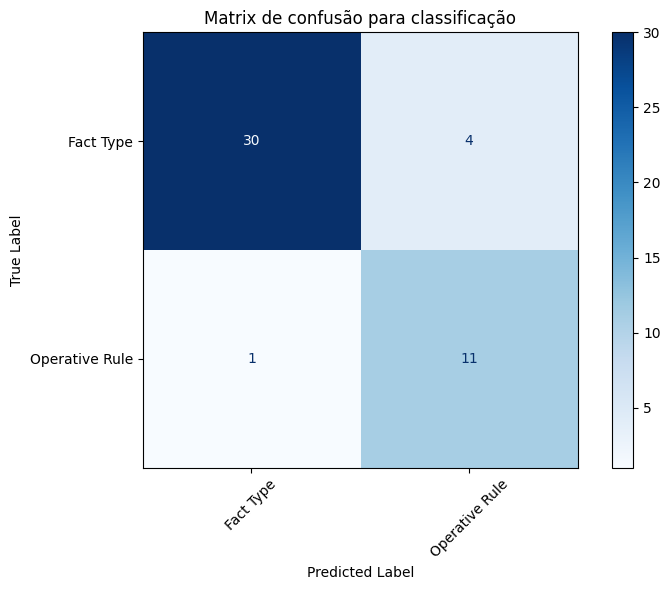

Classification Report:

                precision    recall  f1-score   support

     Fact Type     0.9677    0.8824    0.9231        34
Operative Rule     0.7333    0.9167    0.8148        12

      accuracy                         0.8913        46
     macro avg     0.8505    0.8995    0.8689        46
  weighted avg     0.9066    0.8913    0.8948        46



In [214]:
create_df_elements_results_confusion_matrix_classification(df_elements_results)

Analyzing the Distribution of Similarity Classifications

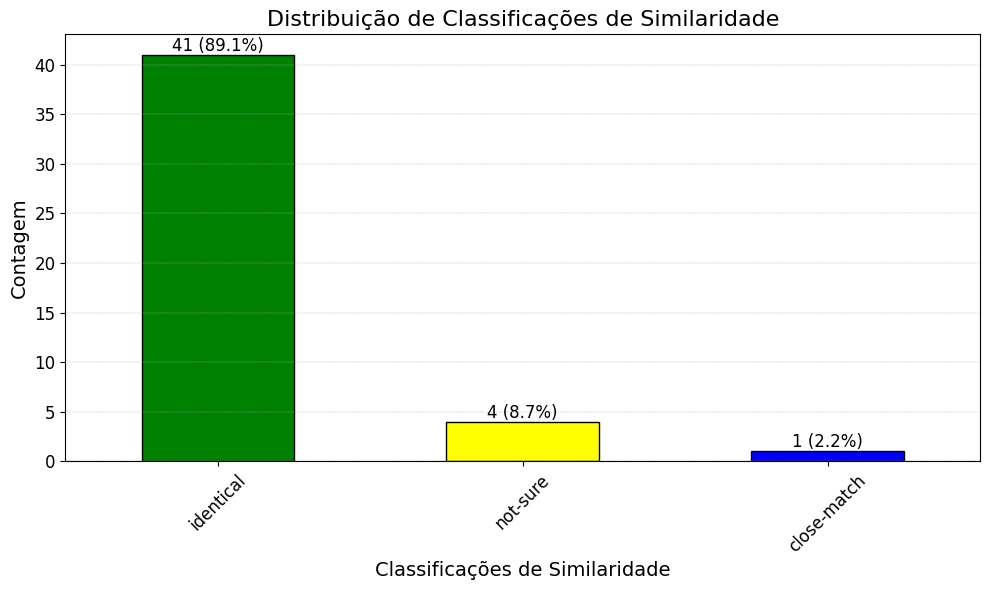

In [215]:
create_elements_results_distribution_similarity(df_elements_results)

**Source identification**

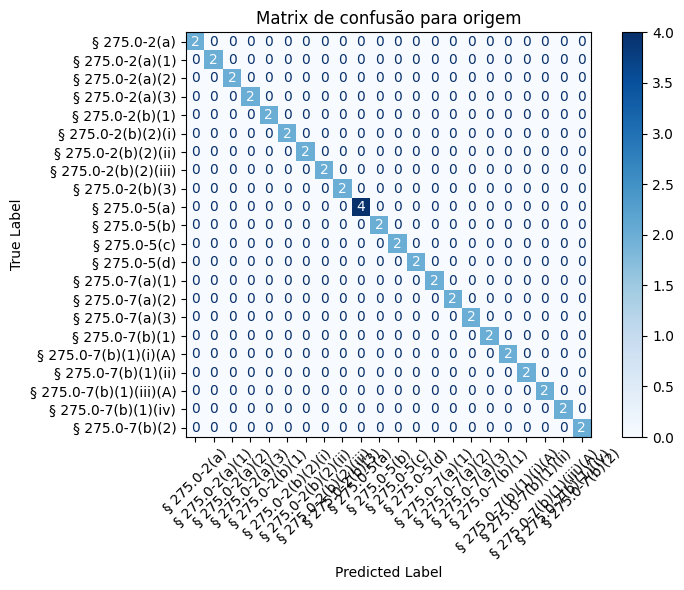

Classification Report:

                         precision    recall  f1-score   support

           § 275.0-2(a)     1.0000    1.0000    1.0000         2
        § 275.0-2(a)(1)     1.0000    1.0000    1.0000         2
        § 275.0-2(a)(2)     1.0000    1.0000    1.0000         2
        § 275.0-2(a)(3)     1.0000    1.0000    1.0000         2
        § 275.0-2(b)(1)     1.0000    1.0000    1.0000         2
     § 275.0-2(b)(2)(i)     1.0000    1.0000    1.0000         2
    § 275.0-2(b)(2)(ii)     1.0000    1.0000    1.0000         2
   § 275.0-2(b)(2)(iii)     1.0000    1.0000    1.0000         2
        § 275.0-2(b)(3)     1.0000    1.0000    1.0000         2
           § 275.0-5(a)     1.0000    1.0000    1.0000         4
           § 275.0-5(b)     1.0000    1.0000    1.0000         2
           § 275.0-5(c)     1.0000    1.0000    1.0000         2
           § 275.0-5(d)     1.0000    1.0000    1.0000         2
        § 275.0-7(a)(1)     1.0000    1.0000    1.0000         2


In [216]:
create_df_elements_results_confusion_matrix_source(df_elements_results)

Analyzing the Distribution of Similarity Classifications

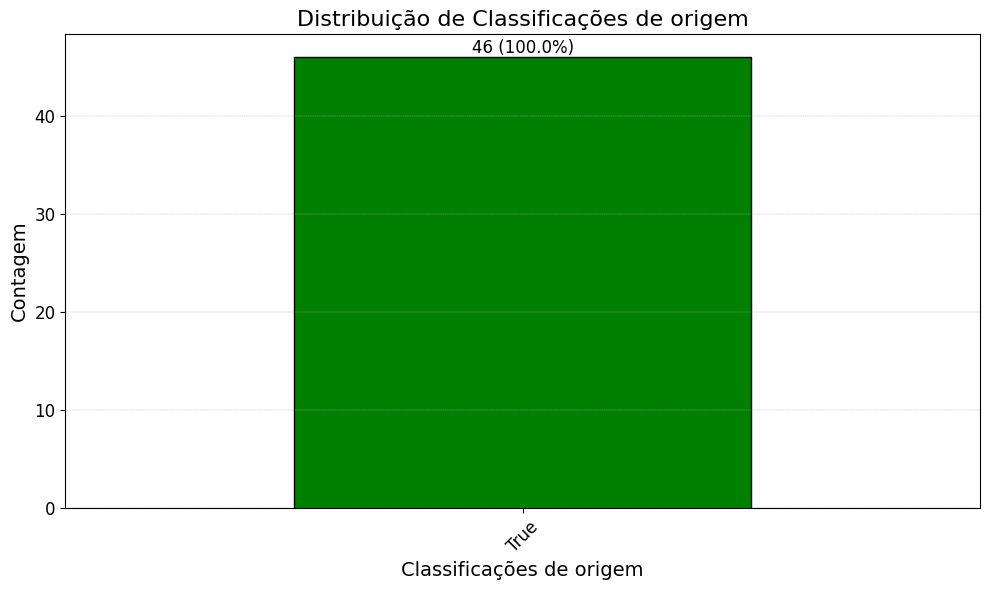

In [217]:
create_elements_results_distribution_source(df_elements_results)

##### Extract term's definition

In [218]:
# Read true terms
true_terms_file = f'{config["DEFAULT_DATA_DIR"]}/p2_true_table.json'
true_terms = read_true_terms(true_terms_file)

In [219]:
true_terms

{'§ 275.0-2': {'Managing agent': {'definition': 'Any person, including a trustee, who directs or manages, or who participates in directing or managing, the affairs of any unincorporated organization or association other than a partnership.'},
  'Partnership': {'definition': None},
  'Non-resident general partner': {'definition': None},
  'Named party': {'definition': None},
  'Non-resident': {'definition': 'An individual who resides in any place not subject to the jurisdiction of the United States; a corporation that is incorporated in or that has its principal office and place of business in any place not subject to the jurisdiction of the United States; and a partnership or other unincorporated organization or association that has its principal office and place of business in any place not subject to the jurisdiction of the United States.'},
  'Pleadings': {'definition': None},
  'Place': {'definition': None},
  'Person': {'definition': None},
  'Association': {'definition': None},
 

In [220]:
# Read predicted terms
json_files_path = f'{config["DEFAULT_CHECKPOINT_DIR"]}/*.json'
pred_terms = read_pred_terms(json_files_path)

In [221]:
# Run the similarity check
similarity_terms_results = check_for_definitions_similarity(true_terms, pred_terms)

Total terms in true_terms: 82
Total matched terms in pred_terms: 82


Create a dataframe of true and pred elements

In [222]:
df_terms_results = create_df_terms_results(similarity_terms_results)

Show the first 10 terms in dataFrame. Yellow means above 80%, red means above 50%.

In [223]:
df_terms_results_styled = df_terms_results.head(10).style.apply(highlight_differences, axis=1)

print("Styled DataFrame with Highlighted Similarity Scores:")
df_terms_results_styled

Styled DataFrame with Highlighted Similarity Scores:


,doc_id,term,definition_pred,definition_true,similarity_score
0,§ 275.0-2,Managing agent,"Any person, including a trustee, who directs or manages, or who participates in directing or managing, the affairs of any unincorporated organization or association other than a partnership.","Any person, including a trustee, who directs or manages, or who participates in directing or managing, the affairs of any unincorporated organization or association other than a partnership.",1.000000
1,§ 275.0-2,Partnership,A partnership that has its principal office and place of business in any place not subject to the jurisdiction of the United States.,,0.000000
2,§ 275.0-2,Non-resident general partner,A general partner of an investment adviser who resides in any place not subject to the jurisdiction of the United States.,,0.000000
3,§ 275.0-2,Named party,"Each party named in the process, pleadings, or papers served on the Commission.",,0.000000
4,§ 275.0-2,Non-resident,"An individual, corporation, partnership, or unincorporated organization that resides or has its principal office and place of business in any place not subject to the jurisdiction of the United States.",An individual who resides in any place not subject to the jurisdiction of the United States; a corporation that is incorporated in or that has its principal office and place of business in any place not subject to the jurisdiction of the United States; and a partnership or other unincorporated organization or association that has its principal office and place of business in any place not subject to the jurisdiction of the United States.,0.419501
5,§ 275.0-2,Pleadings,"Documents served on a non-resident investment adviser, general partner, or managing agent.",,0.000000
6,§ 275.0-2,Place,A location not subject to the jurisdiction of the United States.,,0.000000
7,§ 275.0-2,Person,"An individual or entity involved in serving process, pleadings, or papers.",,0.000000
8,§ 275.0-2,Association,An association that has its principal office and place of business in any place not subject to the jurisdiction of the United States.,,0.000000
9,§ 275.0-2,Non-resident managing agent,A managing agent of an investment adviser who resides in any place not subject to the jurisdiction of the United States.,,0.000000


Histogram of Similarity Scores

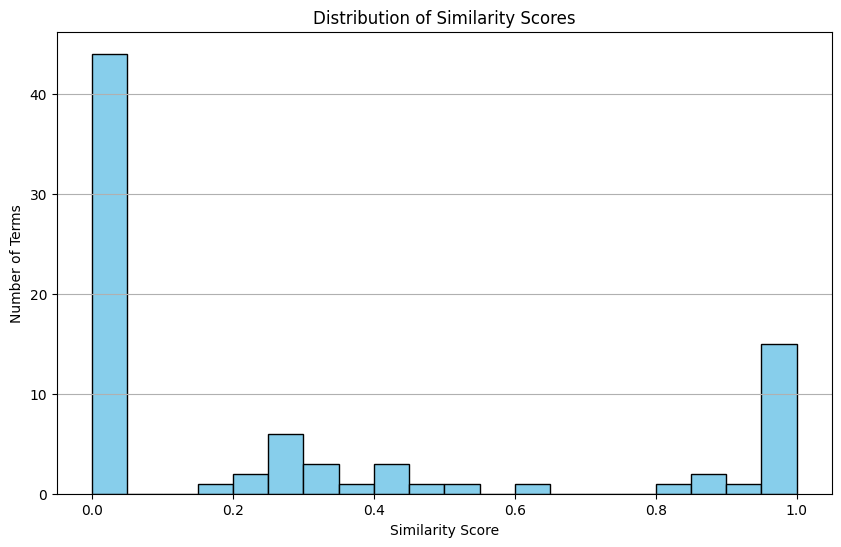

In [224]:
create_terms_results_distribution_similarity(df_terms_results)

Terms with Lowest Similarity Scores

In [225]:
# Identify Terms with Low Similarity Scores
df_sorted = df_terms_results.sort_values(by='similarity_score')

print("Top 10 Terms with Lowest Similarity Scores:")
display(df_sorted.head(10))

Top 10 Terms with Lowest Similarity Scores:


,doc_id,term,definition_pred,definition_true,similarity_score
70,§ 275.0-7,Balance sheet,,The total assets as shown on the balance sheet...,0.0
24,§ 275.0-2,Jurisdiction of the United States,The legal authority or control of the United S...,,0.0
25,§ 275.0-2,Affairs,Activities directed or managed by a managing a...,,0.0
26,§ 275.0-2,Appointed agents,Agents appointed to receive service of process...,,0.0
28,§ 275.0-2,Process,Legal documents served on a non-resident inves...,,0.0
29,§ 275.0-2,Papers,Documents served on a non-resident investment ...,,0.0
30,§ 275.0-2,Secretary,The Secretary of the Commission who forwards d...,,0.0
31,§ 275.0-2,Investment adviser,An adviser who provides investment advice and ...,,0.0
32,§ 275.0-2,Address,The last address filed with the Commission by ...,,0.0
33,§ 275.0-2,Registered mail,A method used by the Secretary to forward docu...,,0.0


Visualize Low Similarity Terms with a Bar Chart

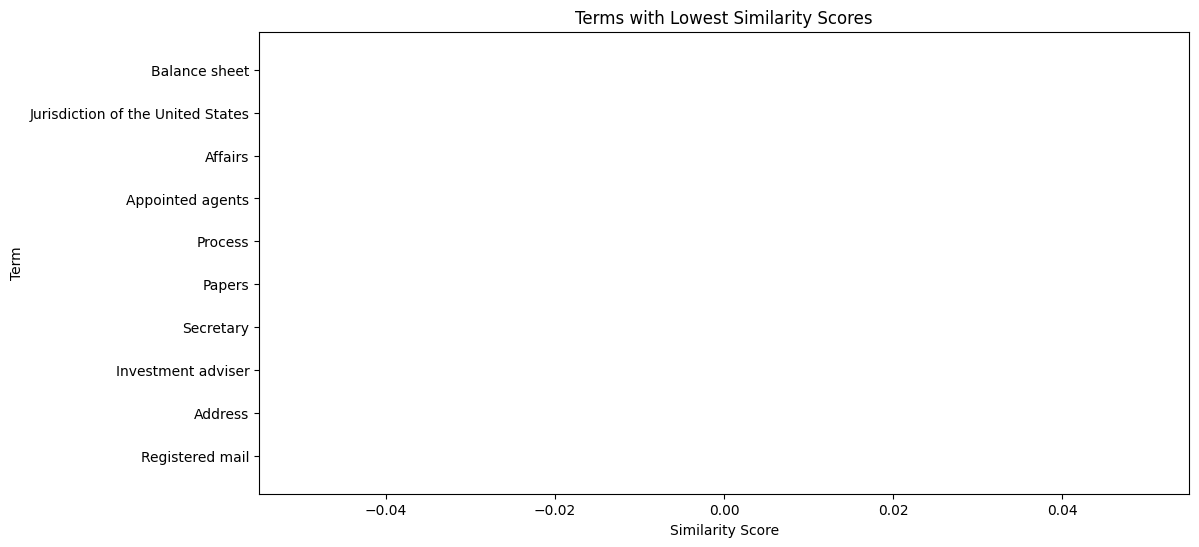

In [226]:
create_terms_results_histogram_low_similarity(df_terms_results, number_of_terms = 10)

Analyze Similarity Scores by Document

Average Similarity Score per Document:


,doc_id,similarity_score
0,§ 275.0-2,0.040557
1,§ 275.0-5,0.423404
2,§ 275.0-7,0.563893


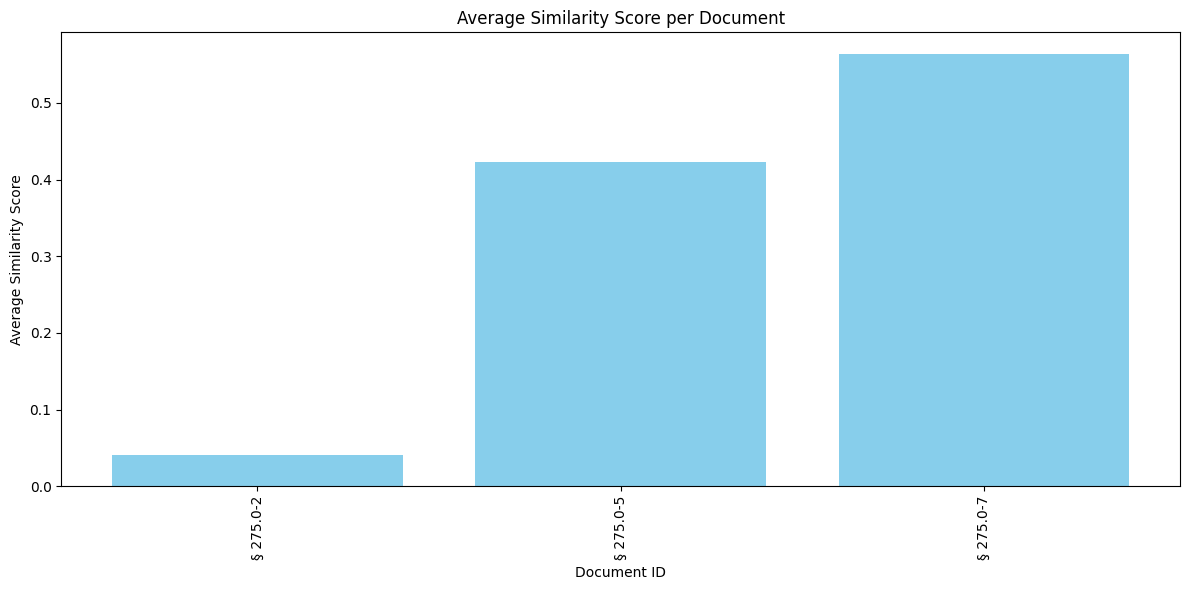

In [227]:
create_terms_results_average_similarity_per_document(df_terms_results)

Heatmap of Similarity Scores

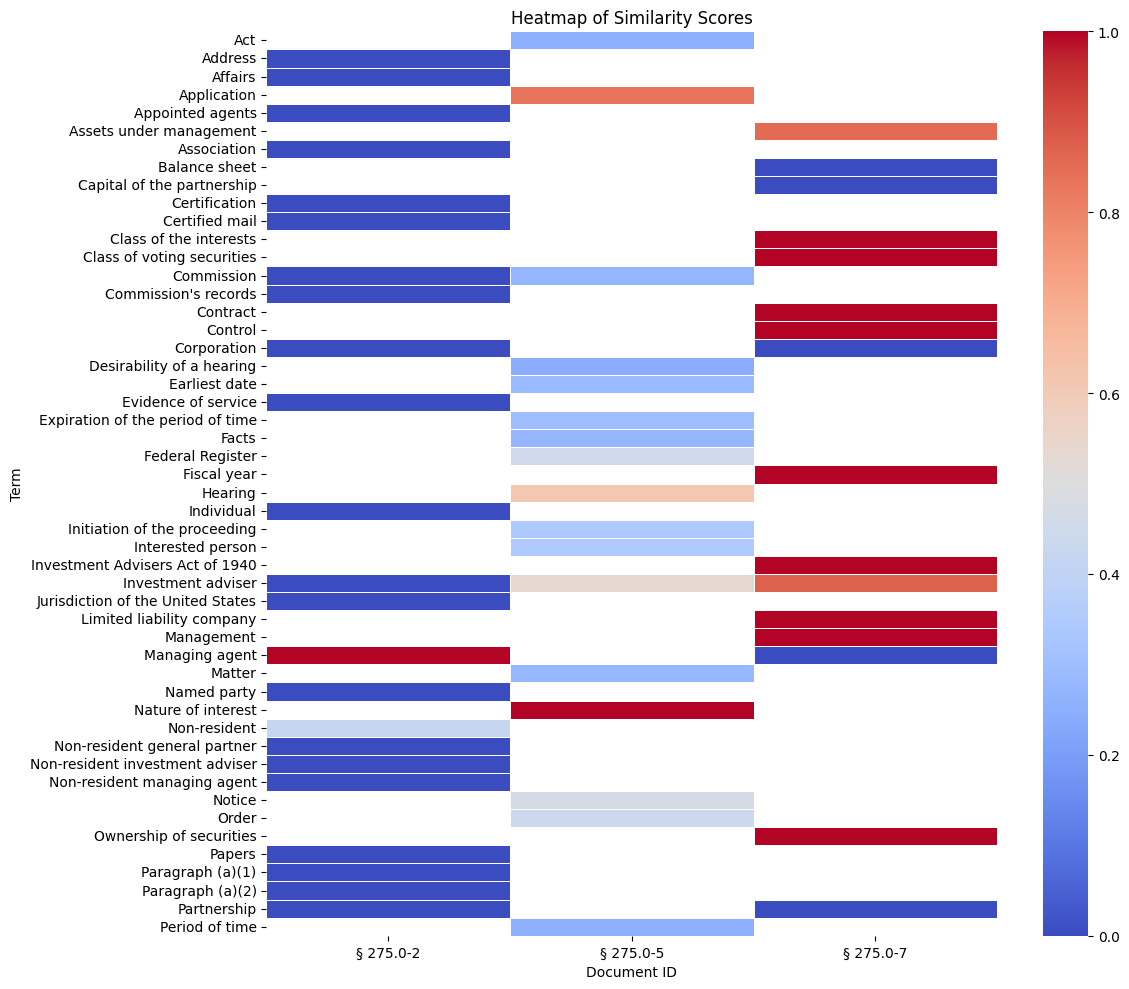

In [228]:
create_terms_results_heatmap(df_terms_results)

Interactive Visualization

In [229]:
fig = px.scatter(df_terms_results, x='term', y='similarity_score',
                 hover_data=['definition_true', 'definition_pred'],
                 title='Similarity Scores per Term')
fig.update_layout(xaxis_title='Term', yaxis_title='Similarity Score')
fig.show()

Save Similarity Results to Excel

In [230]:
excel_filename=f'{config["DEFAULT_OUTPUT_DIR"]}/p2_true_pred_results.xlsx'
df_terms_results.to_excel(excel_filename, index=False)

print(f"Similarity results saved to '{excel_filename}'")

Similarity results saved to '../outputs/p2_true_pred_results.xlsx'


##### Deep analysis of mismatches

Filter the DataFrame to only include rows where similarity_classification is 'not-sure'

In [231]:
df_not_sure = df_elements_results[df_elements_results['similarity_classification'] == 'not-sure']

df_not_sure

,doc_id,id_pred,id_true,classification_pred,classification_true,source_pred,source_true,filename_pred,expression_pred,expression_true,similarity_score,similarity_classification,classification_match,classification_match_label,source_match,source_match_label,id_match,id_match_label
15,§ 275.0-2_P1,7,7,Fact Type,Fact Type,§ 275.0-2(b)(2)(ii),§ 275.0-2(b)(2)(ii),../data/checkpoints/documents-2024-11-01-3.json,Non-resident means a corporation that is incor...,A corporation that is incorporated in or that ...,0.887640,not-sure,True,match,True,match,True,match
37,§ 275.0-7_P1,1,1,Fact Type,Fact Type,§ 275.0-7(a)(1),§ 275.0-7(a)(1),../data/checkpoints/documents-2024-11-01-3.json,An investment adviser has assets under managem...,The term small business or small organization ...,0.396825,not-sure,True,match,True,match,True,match
38,§ 275.0-7_P1,2,2,Fact Type,Fact Type,§ 275.0-7(a)(2),§ 275.0-7(a)(2),../data/checkpoints/documents-2024-11-01-3.json,An investment adviser did not have total asset...,The term small business or small organization ...,0.506494,not-sure,True,match,True,match,True,match
39,§ 275.0-7_P1,3,3,Fact Type,Fact Type,§ 275.0-7(a)(3),§ 275.0-7(a)(3),../data/checkpoints/documents-2024-11-01-3.json,"An investment adviser does not control, is not...",The term small business or small organization ...,0.614865,not-sure,True,match,True,match,True,match


Filter for 'close-match' entries

In [232]:

df_close_match = df_elements_results[df_elements_results['similarity_classification'] == 'close-match']

df_close_match

,doc_id,id_pred,id_true,classification_pred,classification_true,source_pred,source_true,filename_pred,expression_pred,expression_true,similarity_score,similarity_classification,classification_match,classification_match_label,source_match,source_match_label,id_match,id_match_label
16,§ 275.0-2_P1,8,8,Fact Type,Fact Type,§ 275.0-2(b)(2)(iii),§ 275.0-2(b)(2)(iii),../data/checkpoints/documents-2024-11-01-3.json,Non-resident means a partnership or other unin...,A partnership or other unincorporated organiza...,0.901478,close-match,True,match,True,match,True,match


Filter entries where the predicted classification does not match the true classification

In [233]:
df_classification_mismatch = df_elements_results[
    df_elements_results['classification_pred'] != df_elements_results['classification_true']
]

df_classification_mismatch

,doc_id,id_pred,id_true,classification_pred,classification_true,source_pred,source_true,filename_pred,expression_pred,expression_true,similarity_score,similarity_classification,classification_match,classification_match_label,source_match,source_match_label,id_match,id_match_label
18,§ 275.0-5_P1,1,1,Fact Type,Operative Rule,§ 275.0-5(a),§ 275.0-5(a),../data/checkpoints/documents-2024-10-30-1.json,Notice of the initiation of the proceeding wil...,Notice of the initiation of the proceeding wil...,1.0,identical,False,mismatch,True,match,True,match
32,§ 275.0-7_P1,5,5,Operative Rule,Fact Type,§ 275.0-7(b)(1)(i)(A),§ 275.0-7(b)(1)(i)(A),../data/checkpoints/documents-2024-10-30-1.json,A person is presumed to control a corporation ...,A person is presumed to control a corporation ...,1.0,identical,False,mismatch,True,match,True,match
33,§ 275.0-7_P1,6,6,Operative Rule,Fact Type,§ 275.0-7(b)(1)(ii),§ 275.0-7(b)(1)(ii),../data/checkpoints/documents-2024-10-30-1.json,A person is presumed to control a partnership ...,A person is presumed to control a partnership ...,1.0,identical,False,mismatch,True,match,True,match
34,§ 275.0-7_P1,7,7,Operative Rule,Fact Type,§ 275.0-7(b)(1)(iii)(A),§ 275.0-7(b)(1)(iii)(A),../data/checkpoints/documents-2024-10-30-1.json,A person is presumed to control a limited liab...,A person is presumed to control a limited liab...,1.0,identical,False,mismatch,True,match,True,match
35,§ 275.0-7_P1,8,8,Operative Rule,Fact Type,§ 275.0-7(b)(1)(iv),§ 275.0-7(b)(1)(iv),../data/checkpoints/documents-2024-10-30-1.json,A person is presumed to control a trust if the...,A person is presumed to control a trust if the...,1.0,identical,False,mismatch,True,match,True,match


In [234]:
df_classification_mismatch = df_elements_results[
    df_elements_results["classification_pred"] != df_elements_results["classification_true"]
]

# Display the filtered DataFrame
print(df_classification_mismatch)

# Select specific columns to display
columns_to_display = [
    "doc_id",
    "id_pred",
    "id_true",
    "classification_pred",
    "classification_true",
    "similarity_score",
]
df_mismatch_selected = df_classification_mismatch[columns_to_display]

print(df_mismatch_selected)

# Iterate over the mismatches and print details
for index, row in df_classification_mismatch.iterrows():
    print(f"Index: {index}")
    print(f"Doc ID: {row['doc_id']}")
    print(
        f"Predicted Classification (ID {row['id_pred']}): {row['classification_pred']}"
    )
    print(f"True Classification (ID {row['id_true']}): {row['classification_true']}")
    print(f"Similarity Score: {row['similarity_score']:.4f}")
    print(f"Predicted Expression: {row['expression_pred']}")
    print(f"True Expression: {row['expression_true']}")
    print("-" * 80)

# Get the number of classification mismatches
num_mismatches = len(df_classification_mismatch)
print(f"Number of classification mismatches: {num_mismatches}")

# Calculate mismatch percentage
total_comparisons = len(
    df_elements_results.dropna(subset=["classification_true", "classification_pred"])
)
mismatch_percentage = (num_mismatches / total_comparisons) * 100

print(f"Mismatch Percentage: {mismatch_percentage:.2f}%")

          doc_id  id_pred  id_true classification_pred classification_true  \
18  § 275.0-5_P1        1        1           Fact Type      Operative Rule   
32  § 275.0-7_P1        5        5      Operative Rule           Fact Type   
33  § 275.0-7_P1        6        6      Operative Rule           Fact Type   
34  § 275.0-7_P1        7        7      Operative Rule           Fact Type   
35  § 275.0-7_P1        8        8      Operative Rule           Fact Type   

                source_pred              source_true  \
18             § 275.0-5(a)             § 275.0-5(a)   
32    § 275.0-7(b)(1)(i)(A)    § 275.0-7(b)(1)(i)(A)   
33      § 275.0-7(b)(1)(ii)      § 275.0-7(b)(1)(ii)   
34  § 275.0-7(b)(1)(iii)(A)  § 275.0-7(b)(1)(iii)(A)   
35      § 275.0-7(b)(1)(iv)      § 275.0-7(b)(1)(iv)   

                                      filename_pred  \
18  ../data/checkpoints/documents-2024-10-30-1.json   
32  ../data/checkpoints/documents-2024-10-30-1.json   
33  ../data/checkpoints/docum

Filter entries where the predicted classification does not match the true classification

In [235]:
df_classification_mismatch = df_elements_results[
    df_elements_results['classification_pred'] != df_elements_results['classification_true']
]

# Display the number of mismatches
num_mismatches = len(df_classification_mismatch)
print(f"Number of classification mismatches: {num_mismatches}")

# Display the mismatches
print(df_classification_mismatch)

Number of classification mismatches: 5
          doc_id  id_pred  id_true classification_pred classification_true  \
18  § 275.0-5_P1        1        1           Fact Type      Operative Rule   
32  § 275.0-7_P1        5        5      Operative Rule           Fact Type   
33  § 275.0-7_P1        6        6      Operative Rule           Fact Type   
34  § 275.0-7_P1        7        7      Operative Rule           Fact Type   
35  § 275.0-7_P1        8        8      Operative Rule           Fact Type   

                source_pred              source_true  \
18             § 275.0-5(a)             § 275.0-5(a)   
32    § 275.0-7(b)(1)(i)(A)    § 275.0-7(b)(1)(i)(A)   
33      § 275.0-7(b)(1)(ii)      § 275.0-7(b)(1)(ii)   
34  § 275.0-7(b)(1)(iii)(A)  § 275.0-7(b)(1)(iii)(A)   
35      § 275.0-7(b)(1)(iv)      § 275.0-7(b)(1)(iv)   

                                      filename_pred  \
18  ../data/checkpoints/documents-2024-10-30-1.json   
32  ../data/checkpoints/documents-2024-10-30-

##### Conclusion

TODO

## Elements validation

From chapter 7.2.3 Terms, facts, and rules

#### SEMSCORE

Evaluate the semantic similarity between the predicted and true expressions. It is used in conjunction with the judgment evaluation for double check.

SEMSCORE (AYNETDINOV;AKBIK, 2024)


In [236]:
client = OpenAI()

def get_embedding(text, model="text-embedding-3-large"):
   text = text.replace("\n", " ")
   return client.embeddings.create(input = [text], model=model).data[0].embedding

def cosine_similarity(embedding1, embedding2):
    # Calcula a similaridade de cosseno entre dois embeddings
    embedding1 = np.array(embedding1)
    embedding2 = np.array(embedding2)
    cos_sim = np.dot(embedding1, embedding2) / (np.linalg.norm(embedding1) * np.linalg.norm(embedding2))
    return cos_sim

def compare_sentences(sentence1, sentence2):
    # Obtem embeddings para as duas frases
    embedding1 = get_embedding(sentence1)
    embedding2 = get_embedding(sentence2)
    # Calcula a similaridade de cosseno entre os embeddings
    #similarity = cosine_similarity(embedding1, embedding2)
    similarity = 1 - cosine(embedding1, embedding2)
    return similarity

Apply the compare_sentences function to two sentences

In [237]:
# Exemplo de uso
original_sentence = "If process, pleadings, or other papers are served on the Commission as described in this section, the Secretary of the Commission (Secretary) will promptly forward a copy to each named party by registered or certified mail at that party's last address filed with the Commission."
tranformed_sentence = "The Secretary of the Commission must promptly forward a copy of the process, pleadings, or other papers to each named party by registered or certified mail at that party's last address filed with the Commission if the process, pleadings, or other papers are served on the Commission."

similarity = compare_sentences(original_sentence, tranformed_sentence)

print(f"tokens original: {estimate_tokens(original_sentence)}")
print(f"tokens transformed: {estimate_tokens(tranformed_sentence)}")
print(f"SEMSCORE is: {similarity:.4f}")

2024-11-01 20:34:03 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2024-11-01 20:34:03 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


tokens original: 53
tokens transformed: 55
SEMSCORE is: 0.9403


### Evaluation criterias (SHANKAR et al., 2024)

Based on the prompt, there are three inferred evaluation criteria that align with the approach proposed by EvalGen (SHANKAR et al., 2024):

1. **Similarity Score**
   - Given the original_sentence and tranformed_sentence, how similar are they from 0 to 1? And how confident are you about your estimation from 0 to 1?

2. **Transformation Accuracy**
   - From 0 to 1, how does the "transformed_sentence" reflect the original_sentence with the structure and phrasing provided by the template?

3. **Grammar and Syntax Accuracy**
   - How is the transformed sentence grammatically correct and syntactically accurate from 0 to 1?

### LLM-as-a-judge

References of the LLM-as-a-judge approach: (WEI; CHEN; LUO, 2024), (DONG; HU; COLLIER, 2024), (ZHENG et al., 2023)

#### General functions

In [238]:
def measure_time(func):
    """
    Decorator to measure the execution time of a function.
    """
    def wrapper(*args, **kwargs):
        start_time = time.perf_counter()
        result = func(*args, **kwargs)
        end_time = time.perf_counter()
        elapsed_time = end_time - start_time
        logger.info(f"Execution time for {func.__name__}: {elapsed_time:.2f} seconds")
        return result
    return wrapper

@measure_time
def query_instruct_llm(system_prompt: str, user_prompt: str, document_model: Any) -> Any:
    """
    Queries the LLM with the given system and user prompts.

    Args:
        system_prompt (str): The system prompt to set the context for the LLM.
        user_prompt (str): The user prompt containing the text to analyze.

    Returns:
        Any: The response from the LLM, parsed into a document_model object.

    Raises:
        Exception: If the API call fails.
    """
    client = instructor.from_openai(OpenAI()) #, mode=instructor.Mode.TOOLS_STRICT)
    resp = client.chat.completions.create(
        model=config["LLM"]["MODEL"],
        response_model=document_model,
        temperature=config["LLM"]["TEMPERATURE"],
        max_tokens=config["LLM"]["MAX_TOKENS"],
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0,
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt},
        ],
    )
    return resp

Transformation

In [239]:
system_transform_prompt = """
You're tasked to transform rules into structured outputs, applying a specified taxonomy and template.

Follow these steps:

1. **Classify the Rule**: 
   - Based on the taxonomy in *Writing Effective Business Rules*, identify the category of the rule provided. Use terms like “Activity Obligation Rule,” “Definitional Rule,” etc.
   
2. **Apply Template Transformation**:
   - Apply the appropriate template, matching the rule’s category, to rephrase the original sentence.
   - Use **Template T49** if the rule falls under **Activity Obligation Rule**.
   - Ensure the sentence reflects whether the action is **obligatory** ("must") or **permissive** ("may").

3. **Return Results in JSON Format**:
   - Follow this format:
     ```json
     { 
       "original_sentence": "<original sentence provided>",
       "transformed_sentence": "<sentence result of applying the template>",
       "category_classification": "<based on the book taxonomy, e.g., Activity Obligation Rule>",
       "template": "<code of the template, e.g., T49>"
     }
     ```

4. **Example**:

   - **Input**:  
     ```
     If process, pleadings, or other papers are served on the Commission as described in this section, the Secretary of the Commission (Secretary) will promptly forward a copy to each named party by registered or certified mail at that party's last address filed with the Commission.
     ```
   
   - **Output**:
     ```json
     { 
       "original_sentence": "If process, pleadings, or other papers are served on the Commission as described in this section, the Secretary of the Commission (Secretary) will promptly forward a copy to each named party by registered or certified mail at that party's last address filed with the Commission.",
       "transformed_sentence": "The Secretary of the Commission must promptly forward a copy of the process, pleadings, or other papers to each named party by registered or certified mail at that party's last address filed with the Commission if the process, pleadings, or other papers are served on the Commission.",
       "category_classification": "Activity Obligation Rule",
       "template": "T49"
     }
     ```
"""

Calling the LLM

In [240]:
pass

Judging

In [241]:
system_eval_prompt = """
# Task

You're an expert in judging sentence similarity and transformation using a template. 

These criteria should support the evaluation process by verifying classification accuracy, template application, and transformation fidelity.

Check the criteria and evaluate the output:

1. **Similarity Score**
   - Given the original_sentence and tranformed_sentence, how similar are they from 0 to 1? And how confident are you about your estimation from 0 to 1?

2. **Transformation Accuracy**
   - From 0 to 1, how does the "transformed_sentence" reflect the original_sentence with the structure and phrasing provided by the template?

3. **Grammar and Syntax Accuracy**
   - How is the transformed sentence grammatically correct and syntactically accurate from 0 to 1?

Record your evaluation in JSON format as follows:

```json
{
    "similarity_score": <Similarity score>,
    "similarity_score_confidence": <Confidence score>,
    "transformation_accuracy": <Transformation score>,
    "grammar_syntax_accuracy": <Grammar score>,
    "findings": ["<Things found during the evaluation and worth to be mentioned>", 
                 "<other things to mention>"
                ]
}
```
"""

Example

In [242]:
original_sentence = "If process, pleadings, or other papers are served on the Commission as described in this section, the Secretary of the Commission (Secretary) will promptly forward a copy to each named party by registered or certified mail at that party's last address filed with the Commission."

tranformed_sentence = "The Secretary of the Commission must promptly forward a copy of the process, pleadings, or other papers to each named party by registered or certified mail at that party's last address filed with the Commission if the process, pleadings, or other papers are served on the Commission."

template = """
{Each|A|An} < term>
{<qualifying clause 1> | }

{must {not | } <verb phrase 1> {<object 1> | }
{<qualifying clause 2> | } |

may <verb phrase 2> {<object 2> | }
{<qualifying clause 3> | } only}

< time restriction 1> {{and|or} < time restriction 2> | }
{{if |unless} <conditional clause> | }.
"""

In [243]:
user_eval_prompt = f"""
# original_sentence
{original_sentence}

# transformed_sentence
{tranformed_sentence}

# template
{template}
"""

In [244]:
print(system_eval_prompt)


# Task

You're an expert in judging sentence similarity and transformation using a template. 

These criteria should support the evaluation process by verifying classification accuracy, template application, and transformation fidelity.

Check the criteria and evaluate the output:

1. **Similarity Score**
   - Given the original_sentence and tranformed_sentence, how similar are they from 0 to 1? And how confident are you about your estimation from 0 to 1?

2. **Transformation Accuracy**
   - From 0 to 1, how does the "transformed_sentence" reflect the original_sentence with the structure and phrasing provided by the template?

3. **Grammar and Syntax Accuracy**
   - How is the transformed sentence grammatically correct and syntactically accurate from 0 to 1?

Record your evaluation in JSON format as follows:

```json
{
    "similarity_score": <Similarity score>,
    "similarity_score_confidence": <Confidence score>,
    "transformation_accuracy": <Transformation score>,
    "grammar_s

In [245]:
print(user_eval_prompt)


# original_sentence
If process, pleadings, or other papers are served on the Commission as described in this section, the Secretary of the Commission (Secretary) will promptly forward a copy to each named party by registered or certified mail at that party's last address filed with the Commission.

# transformed_sentence
The Secretary of the Commission must promptly forward a copy of the process, pleadings, or other papers to each named party by registered or certified mail at that party's last address filed with the Commission if the process, pleadings, or other papers are served on the Commission.

# template

{Each|A|An} < term>
{<qualifying clause 1> | }

{must {not | } <verb phrase 1> {<object 1> | }
{<qualifying clause 2> | } |

may <verb phrase 2> {<object 2> | }
{<qualifying clause 3> | } only}

< time restriction 1> {{and|or} < time restriction 2> | }
{{if |unless} <conditional clause> | }.




Calling LLM

In [246]:
response = query_instruct_llm(
    system_eval_prompt,
    user_eval_prompt,
    str
)

2024-11-01 20:34:08 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-11-01 20:34:08 - INFO - Execution time for query_instruct_llm: 4.53 seconds


In [247]:
print(response)

{
    "similarity_score": 0.95,
    "similarity_score_confidence": 0.9,
    "transformation_accuracy": 0.9,
    "grammar_syntax_accuracy": 1.0,
    "findings": [
        "The transformed sentence maintains the meaning of the original sentence with slight reordering.",
        "The template structure is followed with the use of 'must' and the conditional clause 'if'.",
        "The grammar and syntax of the transformed sentence are correct."
    ]
}


## Prompt analysis

### Execution of the experiment

Analyze number of tokens from prompts and documents from last checkpoint using gpt-4o as a reference model.

According to [OpenAI | models](https://platform.openai.com/docs/models), the maximum number of tokens (context length) for gpt-4o is 128k.

The cost to use gpt-4o is 2.50 USD per 1m tokens in 2024-10-31. Source: [OpenAI | pricing](https://openai.com/pricing).

In [248]:
reference_model = 128_000  # GPT-4o context length
price_per_million_tokens = 2.50  # USD 2024-10-31
last_checkpoint_file = configuration.get_last_filename(
    config["DEFAULT_CHECKPOINT_DIR"], "documents", "json"
)
token_estimates_dict = generate_token_estimates_from_checkpoint(last_checkpoint_file)

# Print token estimates
print("Token estimates:")
for prompt_type, estimates in token_estimates_dict.items():
    print(f"Prompt type: {prompt_type}")
    for section, tokens in estimates.items():
        print(
            f"Section: {section}, Tokens: {humanize.metric(tokens)} "
            f"({round((tokens / reference_model)*100, 2)}% of context lenght; "
            f"Estimate: {round(tokens * (price_per_million_tokens / 1_000_000), 4)} USD)"
        )
    print()

Token estimates:
Prompt type: P1
Section: § 275.0-2, Tokens: 1.23 k (0.96% of context lenght; Estimate: 0.0031 USD)
Section: § 275.0-5, Tokens: 1.05 k (0.82% of context lenght; Estimate: 0.0026 USD)
Section: § 275.0-7, Tokens: 1.39 k (1.08% of context lenght; Estimate: 0.0035 USD)
Section: average, Tokens: 1.22 k (0.95% of context lenght; Estimate: 0.0031 USD)

Prompt type: P2
Section: § 275.0-2, Tokens: 1.01 k (0.79% of context lenght; Estimate: 0.0025 USD)
Section: § 275.0-5, Tokens: 774 (0.6% of context lenght; Estimate: 0.0019 USD)
Section: § 275.0-7, Tokens: 1.13 k (0.89% of context lenght; Estimate: 0.0028 USD)
Section: average, Tokens: 972 (0.76% of context lenght; Estimate: 0.0024 USD)



### Validation of the experiment

In [249]:
# TODO: Calculate the total cost of CFR2SBVR validation.
...

## References

- [Scikit-LLM: Scikit-Learn Meets Large Language Models](https://medium.com/@sayedebad.777/scikit-llm-scikit-learn-meets-large-language-models-986ff149abcc)
- [23 Game-Changing Python Packages You Are Missing Out On](https://medium.com/pythoneers/23-underrated-python-packages-you-didnt-knew-existed-36dbb0a417c0) - 19 Jellyfish
- [Embeddings are underrated](https://technicalwriting.dev/data/embeddings.html)
- [You Should Probably Pay Attention to Tokenizers](https://cybernetist.com/2024/10/21/you-should-probably-pay-attention-to-tokenizers/?utm_source=tldrnewsletter) - Embeddings